# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [8]:
# Installing seaborn with the required version for specific plots
!pip install seaborn==0.11.0

     |████████████████████████████████| 283 kB 21.9 MB/s            
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


In [9]:
# importing required libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, from_unixtime, col, count, sum, desc, max, collect_list, rank, when, dense_rank
from pyspark.sql import DataFrameStatFunctions as statFunc
from pyspark.sql.types import DateType, IntegerType, FloatType, StringType
from pyspark.sql.functions import to_timestamp
from pyspark.sql import Window

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.sql.functions import isnan, when, count, col

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
import pandas as pd

from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import StandardScaler
import time

In [10]:
# create a Spark session
spark = SparkSession.builder \
        .master("local") \
        .appName("Final Project") \
        .getOrCreate()

In [11]:
spark.version

'2.4.0'

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [12]:
# load the data within the cluster
df = spark.read.json("mini_sparkify_event_data.json")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
# Print Schema to know what kind of variables are available

In [14]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



#### Show number of observation and Columns

In [15]:
print((df.count(), len(df.columns)))

(286500, 18)


#### Check NaNs for all Columns

In [16]:
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



#### Check for Null Values

In [17]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



#### No Nan handling required but Null values are deleted

In [18]:
df = df.dropna(how = 'any', subset = ["userId", "sessionId"])

#### New amount of rows

In [19]:
df.count()

286500

Did not change anything. So no missing values in the user and session id were present

#### Show snippet of the Data Frame

In [20]:
pd.DataFrame(df.take(5))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


#### Removing Duplicates 

In [21]:
df = df.distinct()

In [22]:
df.count()

286500

Amount of rows did not change so no duplicates are within the data set

#### Checking User IDs

In [23]:
df.select("userId").distinct().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



The first two User IDs seems strange, furher investigation for these two is probably necessary. Also one blank userid is present that has to be removed

In [24]:
df = df.filter(df["userId"] != "")

<hr>

#### Defining Churn and creating Target Variable

In [25]:
df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [26]:
df.groupby("page").count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



Only 52 Observations can be considered as positive target variable. The most visited page is NextSong which is not a suprise.

#### Showing all observations were a Cancallation took place

In [27]:
pd.DataFrame(df.filter(df.page == "Cancellation Confirmation").distinct().collect())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,None,Cancelled,Mahi,F,17,Robinson,None,free,"Houston-The Woodlands-Sugar Land, TX",GET,Cancellation Confirmation,1537898335000,191,None,200,1542038645000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,100022
1,None,Cancelled,Keegan,M,46,Rivera,None,free,"Orlando-Kissimmee-Sanford, FL",GET,Cancellation Confirmation,1535907116000,351,None,200,1542472842000,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...,200020
2,None,Cancelled,Teagan,F,306,Roberts,None,paid,"New Philadelphia-Dover, OH",GET,Cancellation Confirmation,1537634865000,1519,None,200,1541463632000,Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,28
3,None,Cancelled,Troy,M,61,Mathis,None,free,"San Francisco-Oakland-Hayward, CA",GET,Cancellation Confirmation,1537376437000,145,None,200,1540611104000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",100009
4,None,Cancelled,Tina,F,115,Thompson,None,paid,"North Wilkesboro, NC",GET,Cancellation Confirmation,1537208989000,188,None,200,1543073753000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",100015
5,None,Cancelled,Leyla,F,45,Barnes,None,free,"Flint, MI",GET,Cancellation Confirmation,1537964483000,6,None,200,1538753070000,"""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",100006
6,None,Cancelled,Sawyer,M,18,Nelson,None,paid,"Greenville-Anderson-Mauldin, SC",GET,Cancellation Confirmation,1536679150000,109,None,200,1539475237000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",100023
7,None,Cancelled,Rayden,M,185,Phillips,None,free,"Dallas-Fort Worth-Arlington, TX",GET,Cancellation Confirmation,1537550344000,172,None,200,1543143782000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",100021
8,None,Cancelled,Charles,M,7,Harper,None,free,"St. Louis, MO-IL",GET,Cancellation Confirmation,1531679695000,267,None,200,1541120964000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",200011
9,None,Cancelled,James,M,74,Mann,None,free,"Birmingham-Hoover, AL",GET,Cancellation Confirmation,1533247234000,17,None,200,1540062847000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100017


#### Generate new column with churn flag

In [28]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [29]:
df = df.withColumn("churned", flag_churn_event("page"))

It can be the case that a customer used the service multiple times and then churned later. That he churned has to 
be noted then for all of his privious sessions as well.

In [30]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [31]:
df = df.withColumn("churned", sum("churned").over(windowval))

In [32]:
pd.DataFrame(df.collect())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,None,Logged In,Darianna,F,34,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Logout,1538016340000,187,None,307,1542823952000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
1,Lily Allen,Logged In,Darianna,F,33,Carpenter,185.25995,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,22,200,1542823951000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
2,John Waite,Logged In,Darianna,F,32,Carpenter,269.76608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Missing You,200,1542823682000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
3,Hermano,Logged In,Darianna,F,31,Carpenter,115.90485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Letters From Madrid,200,1542823567000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
4,None,Logged In,Darianna,F,30,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,Roll Advert,1538016340000,187,None,200,1542823257000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278149,None,Logged In,Delaney,F,4,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",GET,Roll Advert,1534627466000,1,None,200,1538376783000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,1
278150,Gorillaz,Logged In,Delaney,F,3,Perez,602.17424,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1534627466000,1,Kids With Guns (Quiet Village Remix),200,1538376747000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,1
278151,None,Logged In,Delaney,F,2,Perez,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",GET,Roll Advert,1534627466000,1,None,200,1538376542000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,1
278152,Lady GaGa / Colby O'Donis,Logged In,Delaney,F,1,Perez,238.54975,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1534627466000,1,Just Dance,200,1538376509000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8...",100001,1


#### Generate overview of how many users churned and how many not in the data set

In [33]:
df_churn = df.select(['userId', 'churned']).dropDuplicates().groupBy('churned').count()

#### Check number of users that did not churn

In [34]:
df_churn.show()

+-------+-----+
|churned|count|
+-------+-----+
|      0|  173|
|      1|   52|
+-------+-----+



#### Check number of sessions where no churn happend

In [35]:
df.groupby("churned").count().show()

+-------+------+
|churned| count|
+-------+------+
|      0|233290|
|      1| 44864|
+-------+------+



#### Have a look on which users churned 

In [36]:
df.groupby("userId").max("churned").show()

+------+------------+
|userId|max(churned)|
+------+------------+
|100010|           0|
|200002|           0|
|   125|           1|
|   124|           0|
|    51|           1|
|     7|           0|
|    15|           0|
|    54|           1|
|   155|           0|
|100014|           1|
|   132|           0|
|   154|           0|
|   101|           1|
|    11|           0|
|   138|           0|
|300017|           0|
|100021|           1|
|    29|           1|
|    69|           0|
|   112|           0|
+------+------------+
only showing top 20 rows



#### Generating Barplot to compare churn rate

In [37]:
df_churned = df.groupby("userId").max("churned").groupby("max(churned)").count().collect()
df_churned

[Row(max(churned)=0, count=173), Row(max(churned)=1, count=52)]

<AxesSubplot:xlabel='0', ylabel='1'>

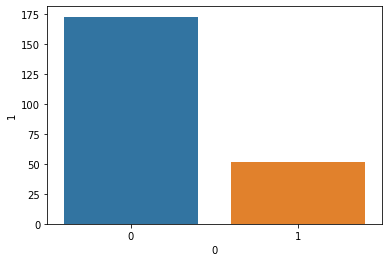

In [38]:
sns.barplot(data = pd.DataFrame(df_churned), x = 0, y = 1)

### EDA

#### Checking if gender has an visible effect

In [39]:
df_gender = df.select(['userId', 'churned', 'gender']).distinct().groupby('gender', 'churned').count()

In [40]:
df_gender.show()

+------+-------+-----+
|gender|churned|count|
+------+-------+-----+
|     F|      0|   84|
|     F|      1|   20|
|     M|      0|   89|
|     M|      1|   32|
+------+-------+-----+



In [41]:
df_gender.withColumn("perc", col("count")/sum("count").over(Window.partitionBy(df_gender["churned"]))).show()

+------+-------+-----+-------------------+
|gender|churned|count|               perc|
+------+-------+-----+-------------------+
|     F|      0|   84|0.48554913294797686|
|     M|      0|   89| 0.5144508670520231|
|     F|      1|   20|0.38461538461538464|
|     M|      1|   32| 0.6153846153846154|
+------+-------+-----+-------------------+



<AxesSubplot:xlabel='churned', ylabel='count'>

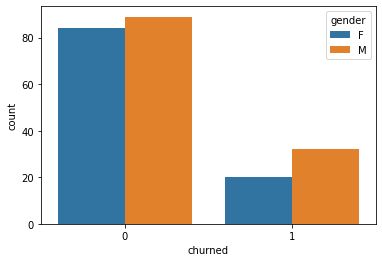

In [42]:
sns.barplot(data = df_gender.toPandas(), x = "churned", y = "count", hue = "gender")

Sligtly more men churned, so it might be that male are more willing to churn

#### Checking if the type of subscritption (free or paid alias Level) has an effect

In [43]:
df_level = df.select(['userId', 'churned', 'level']).distinct().groupBy('level', 'churned').count()
df_level.show()

+-----+-------+-----+
|level|churned|count|
+-----+-------+-----+
| free|      0|  149|
| paid|      0|  129|
| free|      1|   46|
| paid|      1|   36|
+-----+-------+-----+



In [44]:
df_level.withColumn("perc", col("count")/sum("count").over(Window.partitionBy(df_level["churned"]))).show()

+-----+-------+-----+-------------------+
|level|churned|count|               perc|
+-----+-------+-----+-------------------+
| free|      0|  149| 0.5359712230215827|
| paid|      0|  129|0.46402877697841727|
| free|      1|   46| 0.5609756097560976|
| paid|      1|   36|0.43902439024390244|
+-----+-------+-----+-------------------+



#### Generating Barplot for overview

<AxesSubplot:xlabel='churned', ylabel='count'>

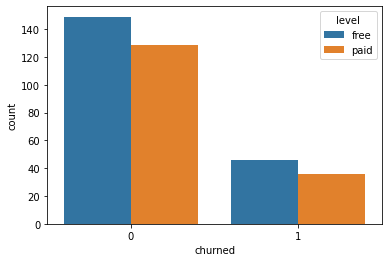

In [45]:
sns.barplot(data = df_level.toPandas(), x = "churned", y = "count", hue = "level")

Looks like a membership slightly benefits a non churning event.

#### Checking effect of Page Visits and Churn

In [46]:
df_page = df.select(['userId', 'churned', 'page']).distinct().groupBy('page','churned').count()

In [47]:
df_page.show(60)

+--------------------+-------+-----+
|                page|churned|count|
+--------------------+-------+-----+
|            Settings|      0|  152|
|         Thumbs Down|      1|   48|
|           Thumbs Up|      1|   50|
|     Add to Playlist|      1|   50|
|               Error|      1|   22|
|               About|      1|   31|
|         Thumbs Down|      0|  155|
|         Roll Advert|      1|   50|
|                Home|      0|  172|
|Cancellation Conf...|      1|   52|
|               Error|      0|   95|
|              Cancel|      1|   52|
|            Settings|      1|   43|
|          Add Friend|      1|   44|
|             Upgrade|      0|  131|
|           Downgrade|      1|   35|
|              Logout|      1|   46|
|    Submit Downgrade|      1|    9|
|       Save Settings|      0|  102|
|           Thumbs Up|      0|  170|
|           Downgrade|      0|  119|
|      Submit Upgrade|      0|  102|
|         Roll Advert|      0|  157|
|    Submit Downgrade|      0|   40|
|

In [48]:
df_page = df_page.withColumn("perc", col("count")/sum("count").over(Window.partitionBy(df_page["churned"])))
df_page.show(60)

+--------------------+-------+-----+--------------------+
|                page|churned|count|                perc|
+--------------------+-------+-----+--------------------+
|            Settings|      0|  152| 0.06509635974304069|
|         Thumbs Down|      0|  155| 0.06638115631691649|
|                Home|      0|  172| 0.07366167023554604|
|               Error|      0|   95| 0.04068522483940043|
|             Upgrade|      0|  131|0.056102783725910065|
|       Save Settings|      0|  102|  0.0436830835117773|
|           Thumbs Up|      0|  170|  0.0728051391862955|
|           Downgrade|      0|  119|0.050963597430406855|
|      Submit Upgrade|      0|  102|  0.0436830835117773|
|         Roll Advert|      0|  157| 0.06723768736616702|
|    Submit Downgrade|      0|   40|0.017130620985010708|
|              Logout|      0|  167|  0.0715203426124197|
|          Add Friend|      0|  162| 0.06937901498929336|
|               About|      0|  124| 0.05310492505353319|
|     Add to P

#### Generating Barplot for better overview

<AxesSubplot:xlabel='perc', ylabel='page'>

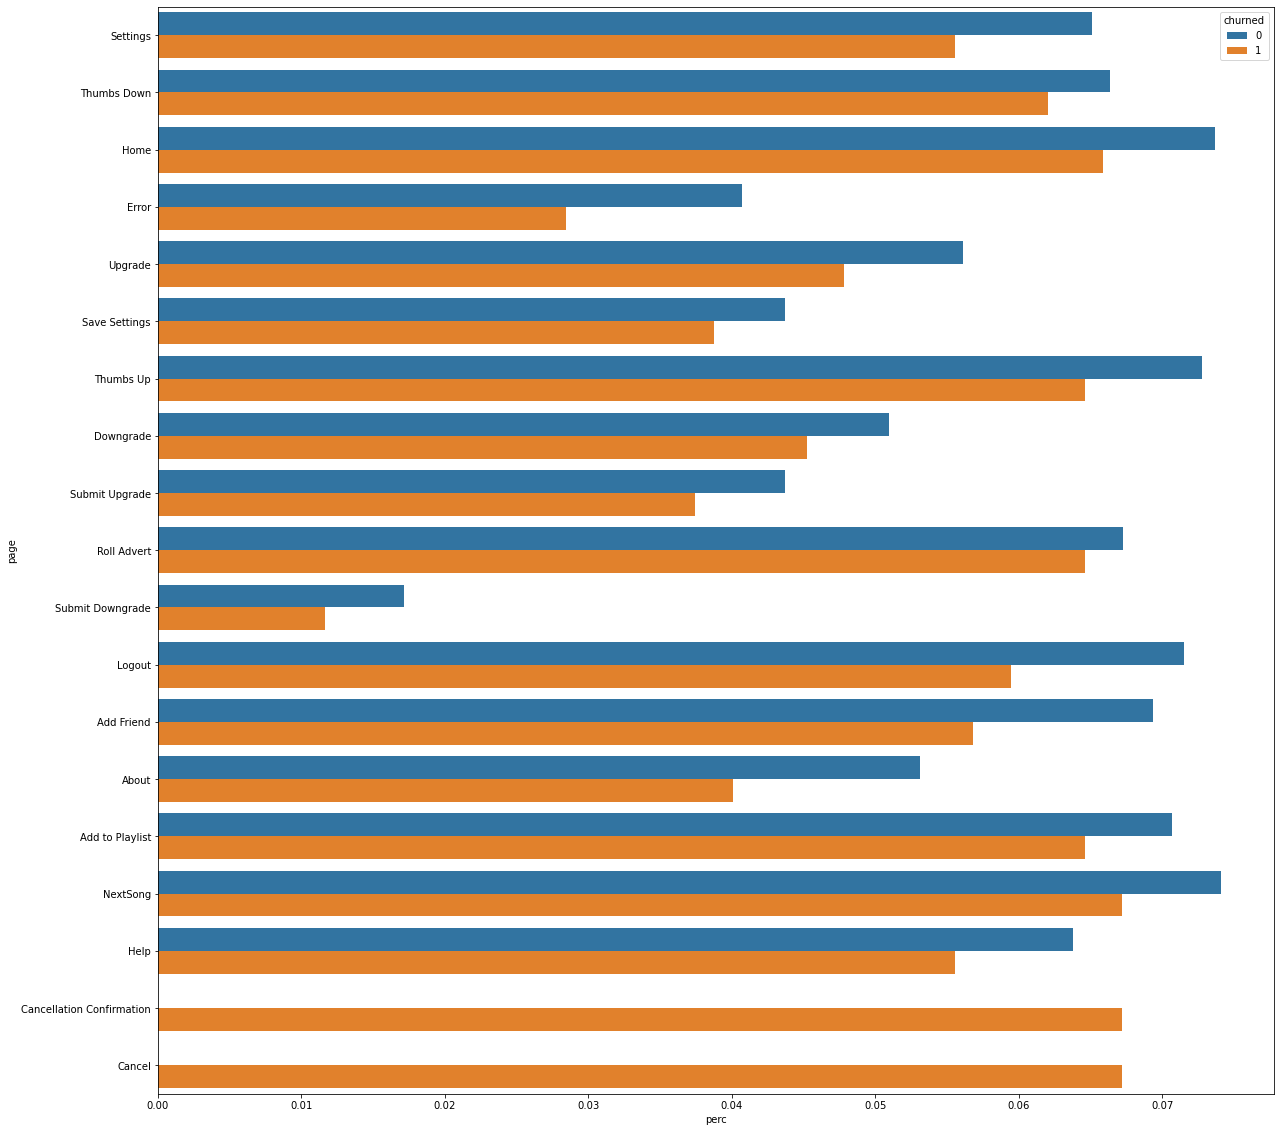

In [49]:
plt.figure(figsize = [20,20])
sns.barplot(data = df_page.toPandas(), x = 'perc', y = 'page', hue = 'churned')

#### Checking if Usage Intensity by viewing the number of unique artist listed has an effect on churn

In [50]:
df_artist = df.select(['artist', 'userId', 'churned']).distinct().groupby('userId','churned').count()
df_artist.show()

+------+-------+-----+
|userId|churned|count|
+------+-------+-----+
|100010|      0|  253|
|200002|      0|  340|
|   125|      1|    9|
|   124|      0| 2233|
|    51|      1| 1386|
|     7|      0|  143|
|    15|      0| 1303|
|    54|      1| 1745|
|   155|      0|  644|
|100014|      1|  234|
|   132|      0| 1300|
|   154|      0|   79|
|   101|      1| 1242|
|    11|      0|  535|
|   138|      0| 1333|
|300017|      0| 2071|
|100021|      1|  208|
|    29|      1| 1805|
|    69|      0|  866|
|   112|      0|  196|
+------+-------+-----+
only showing top 20 rows



#### Generating average of Artist listened for churn

In [51]:
df_artist.groupby('churned').agg({"count":"avg"}).show()

+-------+-----------------+
|churned|       avg(count)|
+-------+-----------------+
|      0|750.7803468208092|
|      1|519.6923076923077|
+-------+-----------------+



<AxesSubplot:xlabel='churned', ylabel='count'>

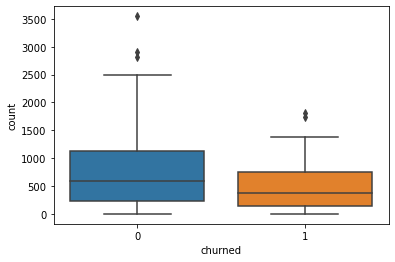

In [52]:
sns.boxplot(data = df_artist.toPandas(), x = 'churned', y='count')

This is not suprising. People who will not like the service will probably not use it as much an thus also in general
use less unique artist. An alternative explaination could be that people who do not know many artist or have a shallow music taste
do not benefit as much from a music plattform with thousands of artist and therefore churn earlier. 

#### Checking User Intensity by viewing numbers of songs listen too per hour

In [53]:
get_hour = udf(lambda x: datetime.fromtimestamp(x / 1000.0).hour)
df = df.withColumn("hour", get_hour(df.ts))

In [54]:
songs_per_hour = df.filter((df.page == "NextSong")).groupby([df.hour, df.churned]).count().orderBy(df.hour.cast("float"))

In [55]:
songs_per_hour.show(48)

+----+-------+-----+
|hour|churned|count|
+----+-------+-----+
|   0|      1| 1535|
|   0|      0| 7527|
|   1|      1| 1353|
|   1|      0| 7035|
|   2|      0| 7014|
|   2|      1| 1322|
|   3|      1| 1292|
|   3|      0| 7063|
|   4|      1| 1233|
|   4|      0| 6914|
|   5|      1| 1218|
|   5|      0| 6960|
|   6|      0| 6836|
|   6|      1| 1218|
|   7|      0| 6873|
|   7|      1| 1218|
|   8|      0| 7023|
|   8|      1| 1230|
|   9|      0| 7268|
|   9|      1| 1230|
|  10|      1| 1380|
|  10|      0| 7502|
|  11|      0| 7440|
|  11|      1| 1390|
|  12|      1| 1408|
|  12|      0| 7918|
|  13|      0| 8073|
|  13|      1| 1571|
|  14|      1| 1702|
|  14|      0| 8792|
|  15|      0| 9462|
|  15|      1| 1892|
|  16|      1| 1915|
|  16|      0| 9721|
|  17|      0| 9464|
|  17|      1| 1996|
|  18|      0| 9146|
|  18|      1| 1978|
|  19|      1| 1818|
|  19|      0| 9112|
|  20|      1| 1749|
|  20|      0| 9107|
|  21|      0| 8853|
|  21|      1| 1605|
|  22|      1

Interrestingly most of the songs are listened between 4 pm and 8 pm

#### Generating Barplot to show song listening tendencies over time

<AxesSubplot:xlabel='hour', ylabel='count'>

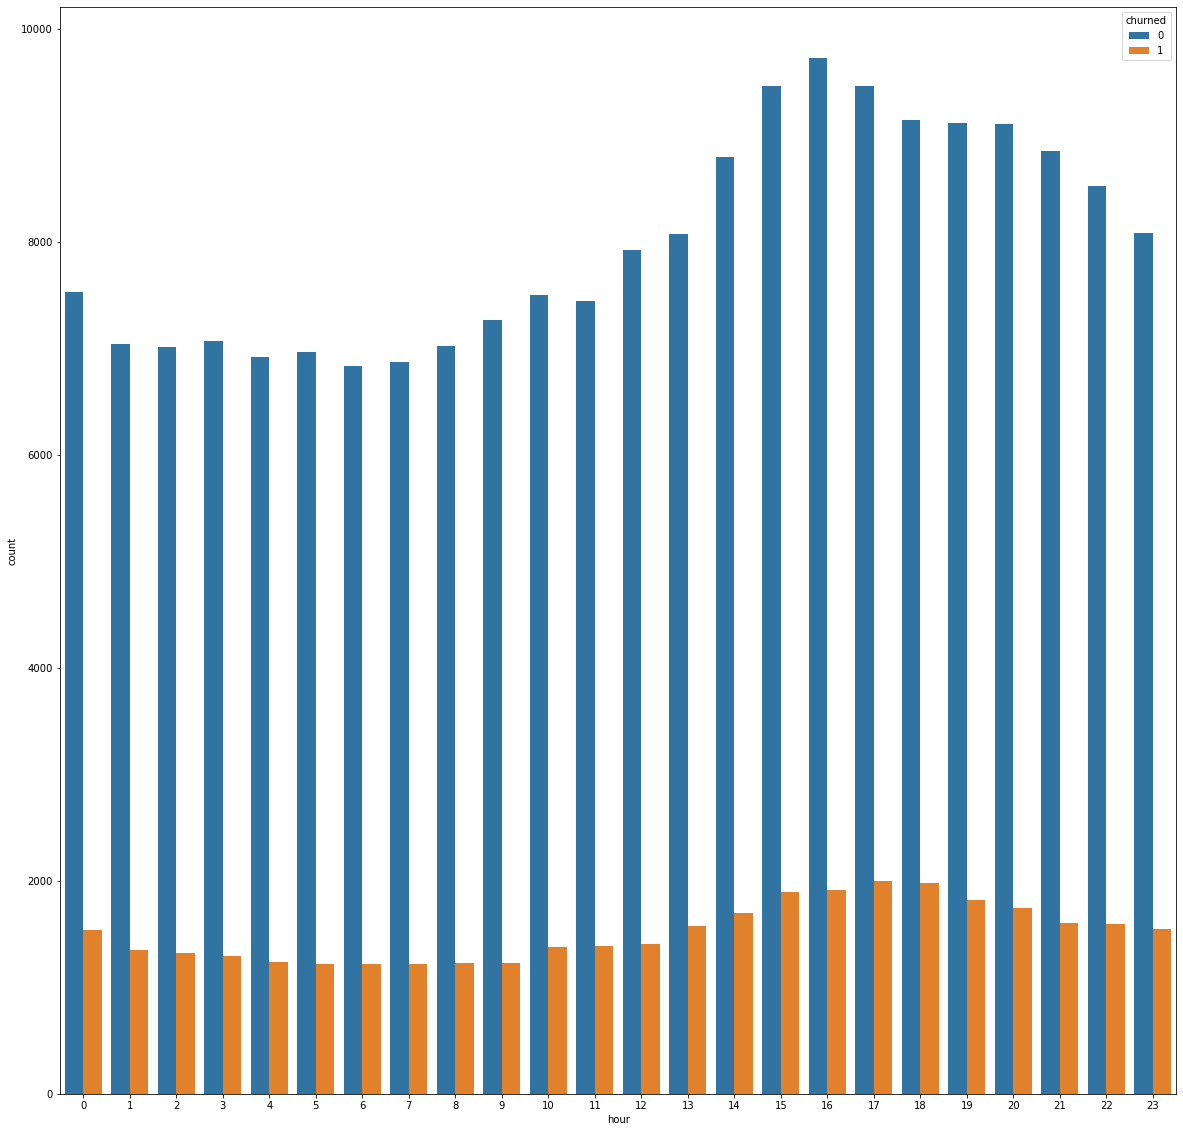

In [56]:
plt.figure(figsize=[20,20])
sns.barplot(data = songs_per_hour.toPandas(), x = "hour", y = "count", hue = "churned")

#### Analyzing if the Membership duration has an effect on Churning rate

In [57]:
df_membership = df.select(['userId', 'registration', 'ts', 'churned']).dropDuplicates().sort('userId')

In [58]:
df_membership.show(10)

+------+-------------+-------------+-------+
|userId| registration|           ts|churned|
+------+-------------+-------------+-------+
|    10|1538159495000|1542630394000|      0|
|    10|1538159495000|1542631090000|      0|
|    10|1538159495000|1542630407000|      0|
|    10|1538159495000|1542631690000|      0|
|    10|1538159495000|1542631517000|      0|
|    10|1538159495000|1542630866000|      0|
|    10|1538159495000|1542630637000|      0|
|    10|1538159495000|1542631788000|      0|
|    10|1538159495000|1542631753000|      0|
|    10|1538159495000|1542631518000|      0|
+------+-------------+-------------+-------+
only showing top 10 rows



#### Calculate time difference between registration days and last ts of usage

In [59]:
usage_win = Window.partitionBy("userId").orderBy(desc("ts"))

In [60]:
df_membership = df_membership.withColumn("Rank", dense_rank().over(usage_win))

In [61]:
df_membership = df_membership.filter(df_membership.Rank == 1).drop(df_membership.Rank)

In [62]:
df_membership = df_membership.withColumn("duration_days", (df_membership['ts']) - (df_membership['registration']))

In [63]:
df_membership = df_membership.withColumn('duration_days',(df_membership['duration_days']/1000/3600/24))

In [64]:
df_membership.show(10)

+------+-------------+-------------+-------+------------------+
|userId| registration|           ts|churned|     duration_days|
+------+-------------+-------------+-------+------------------+
|    10|1538159495000|1542631788000|      0| 51.76265046296297|
|   100|1537982255000|1543587349000|      0| 64.87377314814815|
|100001|1534627466000|1538498205000|      1| 44.80021990740741|
|100002|1529934689000|1543799476000|      0|160.47207175925925|
|100003|1537309344000|1539274781000|      1|22.748113425925926|
|100004|1528560242000|1543459065000|      0|172.44008101851853|
|100005|1532610926000|1539971825000|      1| 85.19559027777778|
|100006|1537964483000|1538753070000|      1| 9.127164351851851|
|100007|1533522419000|1543491909000|      1|115.38761574074074|
|100008|1537440271000|1543335219000|      0| 68.22856481481482|
+------+-------------+-------------+-------+------------------+
only showing top 10 rows



<AxesSubplot:xlabel='churned', ylabel='duration_days'>

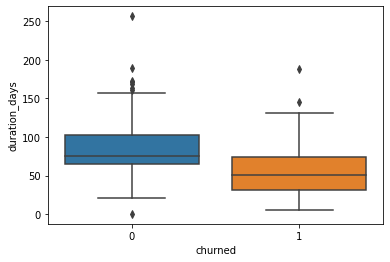

In [65]:
sns.boxplot(data = df_membership.toPandas(), x = 'churned', y ='duration_days')

Not suprisingly user that have longer duration in using the product do not churn as often as lower usage user.

#### Finding the last time the user used the product

In [66]:
last_use_window = Window.partitionBy("userId").orderBy(desc("ts"))

In [67]:
df_membership = df_membership.withColumn("session_order", rank().over(last_use_window))

In [68]:
df_membership = df_membership.filter(df_membership.session_order == 1)

In [69]:
df_membership.show()

+------+-------------+-------------+-------+------------------+-------------+
|userId| registration|           ts|churned|     duration_days|session_order|
+------+-------------+-------------+-------+------------------+-------------+
|    10|1538159495000|1542631788000|      0| 51.76265046296297|            1|
|   100|1537982255000|1543587349000|      0| 64.87377314814815|            1|
|100001|1534627466000|1538498205000|      1| 44.80021990740741|            1|
|100002|1529934689000|1543799476000|      0|160.47207175925925|            1|
|100003|1537309344000|1539274781000|      1|22.748113425925926|            1|
|100004|1528560242000|1543459065000|      0|172.44008101851853|            1|
|100005|1532610926000|1539971825000|      1| 85.19559027777778|            1|
|100006|1537964483000|1538753070000|      1| 9.127164351851851|            1|
|100007|1533522419000|1543491909000|      1|115.38761574074074|            1|
|100008|1537440271000|1543335219000|      0| 68.22856481481482| 

In [70]:
df_membership = df_membership.withColumn("membership_duration", (df_membership['ts']) - (df_membership['registration']))

In [71]:
df_membership = df_membership.withColumn('membership_duration',(df_membership['membership_duration']/1000/3600/24))

In [72]:
df_membership.show()

+------+-------------+-------------+-------+------------------+-------------+-------------------+
|userId| registration|           ts|churned|     duration_days|session_order|membership_duration|
+------+-------------+-------------+-------+------------------+-------------+-------------------+
|    10|1538159495000|1542631788000|      0| 51.76265046296297|            1|  51.76265046296297|
|   100|1537982255000|1543587349000|      0| 64.87377314814815|            1|  64.87377314814815|
|100001|1534627466000|1538498205000|      1| 44.80021990740741|            1|  44.80021990740741|
|100002|1529934689000|1543799476000|      0|160.47207175925925|            1| 160.47207175925925|
|100003|1537309344000|1539274781000|      1|22.748113425925926|            1| 22.748113425925926|
|100004|1528560242000|1543459065000|      0|172.44008101851853|            1| 172.44008101851853|
|100005|1532610926000|1539971825000|      1| 85.19559027777778|            1|  85.19559027777778|
|100006|153796448300

#### Generating histogramms to compare the membership durations between users that churned and that did not

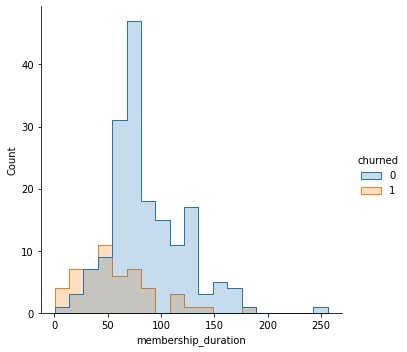

In [73]:
sns.displot(df_membership.toPandas(), x="membership_duration", hue="churned", element="step")

Users that churned are slighlty have a less membership on average or churn on the beginning of ther membership. User that are locked in longer
in the service are not churning that easily.

#### Analyzing if the Length of the sessions do have an affect on churning behavior

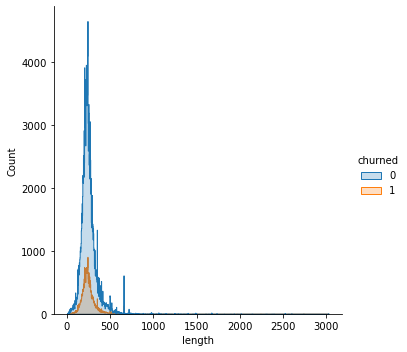

In [74]:
sns.displot(df.toPandas(), x="length", hue="churned", element="step")

Almost no change in the distribution of lenght regarding churn. It looks like churned distribution is slightly more left orientated.

#### Analyzing the Intensity in usage by checking the average number of songs per session

In [75]:
df_songs = df.filter(df.page == "NextSong").distinct().groupBy('sessionId','churned').count()

In [76]:
df_songs = df_songs.groupby('churned').agg({"count":"avg"})

#### Generating Barplot to compared both groups

<AxesSubplot:xlabel='churned', ylabel='avg(count)'>

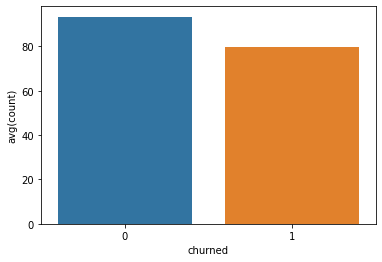

In [77]:
sns.barplot(data = df_songs.toPandas(), x = 'churned', y='avg(count)')

#### Analyzing if there is a connection of  where the users live and the churn behavior

In [78]:
df.select("location", "userId", "churned").groupby("location").count().show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Atlantic City-Ham...| 2176|
|     Gainesville, FL| 1229|
|Cleveland-Elyria, OH| 1392|
|San Diego-Carlsba...|  754|
|Deltona-Daytona B...|   73|
|Kingsport-Bristol...| 1863|
|New Haven-Milford...| 4007|
|Birmingham-Hoover...|   75|
|  Corpus Christi, TX|   11|
|         Dubuque, IA|  651|
|Las Vegas-Henders...| 2042|
|Indianapolis-Carm...|  970|
|Seattle-Tacoma-Be...|  246|
|          Albany, OR|   23|
|   Winston-Salem, NC|  819|
|Los Angeles-Long ...|30131|
|     Bakersfield, CA| 1775|
|Minneapolis-St. P...| 2134|
|San Francisco-Oak...| 2647|
|Allentown-Bethleh...|  815|
+--------------------+-----+
only showing top 20 rows



There will probably be not much connection between the city and churn but the state might have a correlation. Therefore
state information grouping is done.

In [79]:
extract_state = udf(lambda x: x[-2:], StringType())

In [80]:
df_residence = df.withColumn("residence", extract_state(df.location))

In [81]:
df_residence.show(1)

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+-------+----+---------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|  page| registration|sessionId|song|status|           ts|           userAgent|userId|churned|hour|residence|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+--------------------+------+-------+----+---------+
|  null|Logged In| Darianna|     F|           34|Carpenter|  null| free|Bridgeport-Stamfo...|   PUT|Logout|1538016340000|      187|null|   307|1542823952000|"Mozilla/5.0 (iPh...|100010|      0|  18|       CT|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+------+-------------+---------+----+------+-------------+-------

In [82]:
df_residence = df_residence.select(["userId", "residence", "churned"]).groupby(["residence", "churned"]).count()

In [83]:
df_residence.show()

+---------+-------+-----+
|residence|churned|count|
+---------+-------+-----+
|       AL|      0| 3471|
|       IL|      0| 6112|
|       AZ|      1|  251|
|       OH|      0|  259|
|       AL|      1| 2102|
|       PA|      0|23708|
|       NV|      0| 2042|
|       PA|      1| 2899|
|       OH|      1| 3173|
|       UT|      0| 1102|
|       MO|      1| 1003|
|       FL|      1| 1763|
|       MT|      1|  254|
|       NC|      0|10572|
|       IN|      1|  918|
|       TX|      1| 1294|
|       MT|      0| 2132|
|       KY|      0|  446|
|       KS|      1|  513|
|       MA|      0|  927|
+---------+-------+-----+
only showing top 20 rows



#### Generating barplot to show churn behavior based on state

<AxesSubplot:xlabel='count', ylabel='residence'>

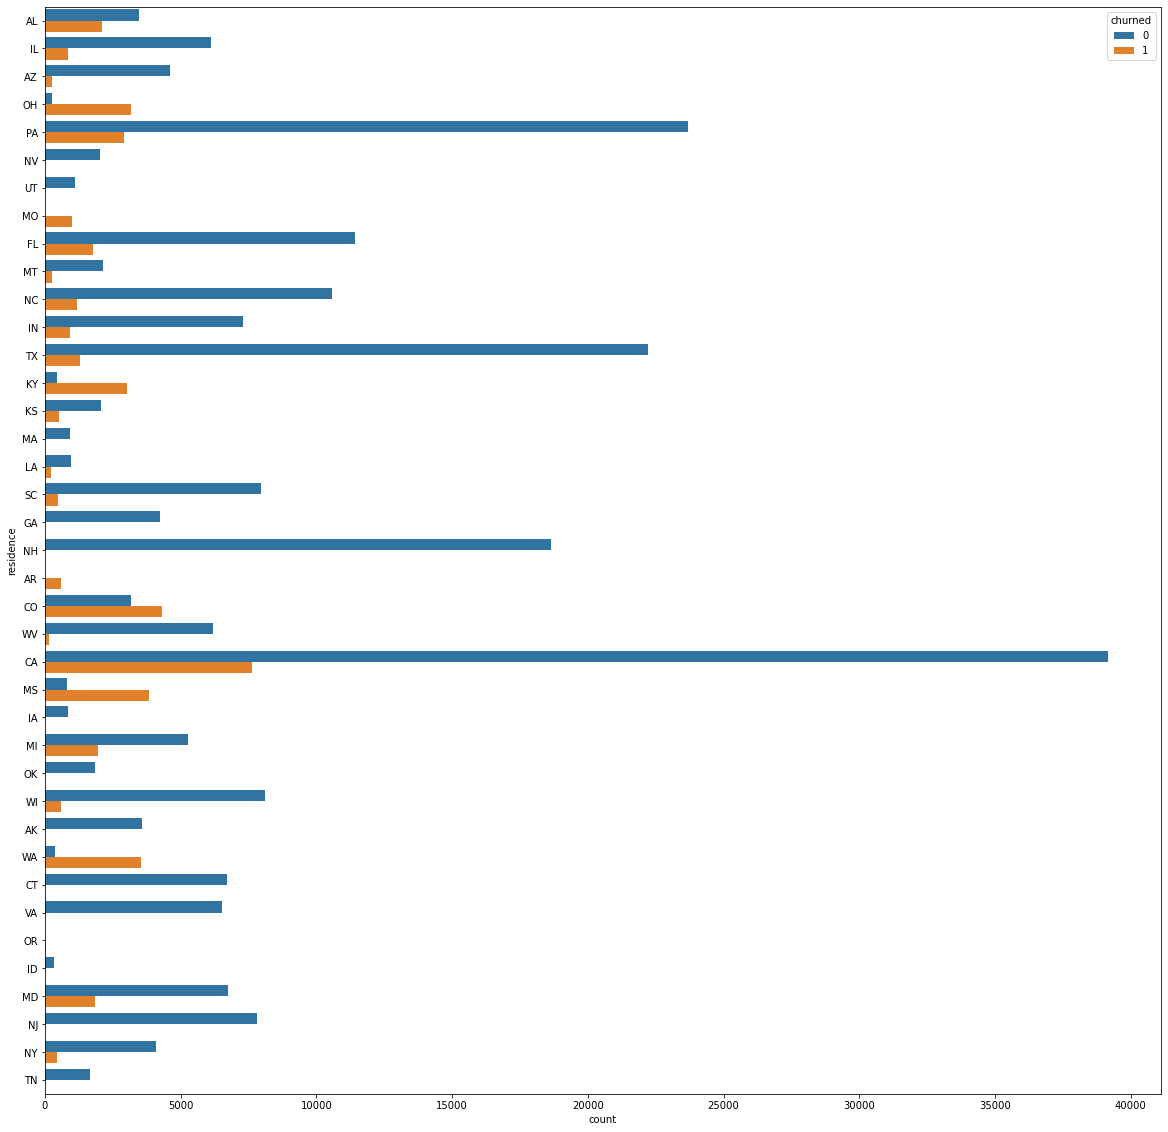

In [84]:
plt.figure(figsize=[20,20])
sns.barplot(data = df_residence.toPandas(), x = 'count', y = 'residence', hue = 'churned')

Some states cleary stand out, like Colorado, Missouri or Washington. So this variable might be a good dependent variable for modelling.

#### Types of system used for accessing the service

Windows vs Macintosh could give insights about user purchasing power and might also give other insights like
different usability that could lead to different churn behavior based on the system used.

In [85]:
df_system = df.select("userId", "userAgent", "churned").distinct()

In [86]:
df_system.groupby(["userAgent", "churned"]).count().show()

+--------------------+-------+-----+
|           userAgent|churned|count|
+--------------------+-------+-----+
|"Mozilla/5.0 (Win...|      0|    9|
|"Mozilla/5.0 (Mac...|      0|    1|
|"Mozilla/5.0 (Win...|      1|    5|
|Mozilla/5.0 (X11;...|      1|    1|
|"Mozilla/5.0 (Win...|      0|    1|
|"Mozilla/5.0 (Win...|      0|    2|
|Mozilla/5.0 (Wind...|      1|    1|
|"Mozilla/5.0 (iPh...|      0|    4|
|"Mozilla/5.0 (Win...|      0|    3|
|Mozilla/5.0 (Wind...|      1|    1|
|"Mozilla/5.0 (X11...|      0|    1|
|Mozilla/5.0 (Wind...|      0|    3|
|"Mozilla/5.0 (Mac...|      0|    1|
|Mozilla/5.0 (Wind...|      0|   14|
|"Mozilla/5.0 (Mac...|      1|    3|
|"Mozilla/5.0 (Win...|      1|    1|
|"Mozilla/5.0 (Mac...|      1|    5|
|"Mozilla/5.0 (Win...|      1|    1|
|"Mozilla/5.0 (Mac...|      0|    1|
|"Mozilla/5.0 (iPa...|      0|    1|
+--------------------+-------+-----+
only showing top 20 rows



#### Show all unique values in the column userAgent

In [87]:
df_system.select("userAgent").distinct().collect()

[Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Macintosh; Intel Mac OS X 10.7; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW6

Cardinality is to high. It needs to be brought down to more common values.

#### Collecting only rows where Windows is present

In [88]:
df.filter(df.userAgent.like("%Windows%")).select("userAgent").distinct().collect()

[Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:30.0) Gecko/20100101 Firefox/30.0'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.3; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"'),
 Row(userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)'),
 Row(userAgent='Mozilla/5.0 (compatible; 

#### Creating new Column with possible values Windows, Macintosh and I_System

In [89]:
df_system = df_system.withColumn(
    'System',
     when(col("userAgent").contains("Windows"), "Windows")\
    .when(col("userAgent").contains("Macintosh"), "Mac")\
    .when(col("userAgent").contains("iPhone"), "I_System")\
    .when(col("userAgent").contains("iPad"), "I_System")\
    .otherwise("Other")
)

In [90]:
df_system.show()

+------+--------------------+-------+--------+
|userId|           userAgent|churned|  System|
+------+--------------------+-------+--------+
|100010|"Mozilla/5.0 (iPh...|      0|I_System|
|200002|"Mozilla/5.0 (iPh...|      0|I_System|
|   125|"Mozilla/5.0 (Mac...|      1|     Mac|
|   124|"Mozilla/5.0 (Mac...|      0|     Mac|
|    51|"Mozilla/5.0 (Win...|      1| Windows|
|     7|Mozilla/5.0 (Wind...|      0| Windows|
|    15|"Mozilla/5.0 (Win...|      0| Windows|
|    54|Mozilla/5.0 (Wind...|      1| Windows|
|   155|"Mozilla/5.0 (Win...|      0| Windows|
|100014|"Mozilla/5.0 (Win...|      1| Windows|
|   132|"Mozilla/5.0 (Mac...|      0|     Mac|
|   154|"Mozilla/5.0 (Win...|      0| Windows|
|   101|Mozilla/5.0 (Wind...|      1| Windows|
|    11|Mozilla/5.0 (Wind...|      0| Windows|
|   138|"Mozilla/5.0 (iPa...|      0|I_System|
|300017|"Mozilla/5.0 (Mac...|      0|     Mac|
|100021|"Mozilla/5.0 (Mac...|      1|     Mac|
|    29|"Mozilla/5.0 (Mac...|      1|     Mac|
|    69|"Mozi

In [91]:
df_system = df_system.groupby(["System", "churned"]).count()
df_system.show()

+--------+-------+-----+
|  System|churned|count|
+--------+-------+-----+
|   Other|      1|    5|
|I_System|      0|   12|
|     Mac|      1|   19|
|I_System|      1|    4|
|     Mac|      0|   67|
|   Other|      0|    7|
| Windows|      0|   87|
| Windows|      1|   24|
+--------+-------+-----+



#### Generating Barplot to compare newly created variables with Churn behavior

<AxesSubplot:xlabel='System', ylabel='count'>

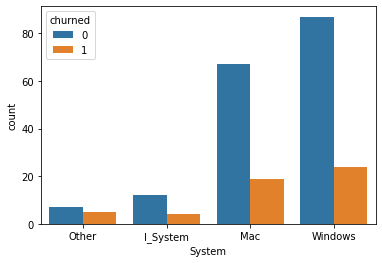

In [92]:
sns.barplot(data = df_system.toPandas(), y = "count", x = "System", hue = "churned")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Print Schema for overview

In [93]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churned: long (nullable = true)
 |-- hour: string (nullable = true)



### Generating Gender Variable

In [94]:
gender_df = df.select(["userId", "gender"]).distinct()
gender_df = gender_df.withColumn("gender", when(col("gender") == "M", 1)\
                                 .when(col("gender") == "F", 0))

In [95]:
gender_df.show(10)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
|    39|     0|
|100010|     0|
|    35|     0|
|    40|     0|
|    75|     0|
+------+------+
only showing top 10 rows



#### Showing the size of the new aggregated data set

In [96]:
gender_df.count()

225

In total 225 users are in the dataset. This aggregation number has to be counted for every new created dataset

### Generating Variable of Mean amount of Songs listen per hour

In [97]:
songs_df = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count().groupby('userId').agg({"count":"avg"})
songs_df = songs_df.withColumnRenamed("avg(count)", "mean_song")

In [98]:
songs_df.show(5)

+------+------------------+
|userId|         mean_song|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



### Generating Variable of Number of unique Singer listened

In [99]:
singer_df = df.select("userId", "artist").distinct().groupby("userId").count()

In [100]:
singer_df = singer_df.withColumnRenamed("count", "nr_singer")

In [101]:
singer_df.show(5)

+------+---------+
|userId|nr_singer|
+------+---------+
|100010|      253|
|200002|      340|
|   125|        9|
|   124|     2233|
|    51|     1386|
+------+---------+
only showing top 5 rows



In [102]:
singer_df.count()

225

### Generating Variable of Days using the product/service

In [103]:
df_membership = df_membership.drop('registration', 'ts', 'churned', 'duration_days')

In [104]:
df_membership = df_membership.drop("session_order")

In [105]:
df_membership.show(10)

+------+-------------------+
|userId|membership_duration|
+------+-------------------+
|    10|  51.76265046296297|
|   100|  64.87377314814815|
|100001|  44.80021990740741|
|100002| 160.47207175925925|
|100003| 22.748113425925926|
|100004| 172.44008101851853|
|100005|  85.19559027777778|
|100006|  9.127164351851851|
|100007| 115.38761574074074|
|100008|  68.22856481481482|
+------+-------------------+
only showing top 10 rows



In [106]:
df_membership.count()

225

### Generating Variable of Songs in Playlist

In [107]:
nr_songs_df = df.select(["userId", "page"])

In [108]:
count_songs = udf(lambda x: 1 if x == "Add to Playlist" else 0, IntegerType())

In [109]:
nr_songs_df = nr_songs_df.withColumn("Songs in Playlist", count_songs("page"))

In [110]:
nr_songs_df = nr_songs_df.groupby("userId").sum("Songs in Playlist")

In [111]:
nr_songs_df.show(10)

+------+----------------------+
|userId|sum(Songs in Playlist)|
+------+----------------------+
|100010|                     7|
|200002|                     8|
|   125|                     0|
|    51|                    52|
|   124|                   118|
|     7|                     5|
|    15|                    59|
|    54|                    72|
|   155|                    24|
|   132|                    38|
+------+----------------------+
only showing top 10 rows



In [112]:
nr_songs_df.count()

225

In [113]:
nr_songs_df = nr_songs_df.withColumnRenamed("sum(Songs in Playlist)", "Songs_in_Playlist")

### Generating Variable of Mean amount of Songs per session listened to 

In [114]:
song_per_session_df = df.filter(df.page == "NextSong").groupBy('userId','sessionId').count().groupby('userId').agg({"count":"avg"})

In [115]:
song_per_session_df = song_per_session_df.withColumnRenamed("avg(count)", "avg_song")

In [116]:
song_per_session_df.count()

225

### Generating Variable of Level/Type of subscription

In [117]:
level_df = df.select(['userId', 'level', 'ts']).distinct().sort('userId')

In [118]:
level_window = Window.partitionBy("userId").orderBy(desc("ts"))

In [119]:
level_df = level_df.withColumn("Rank", dense_rank().over(level_window))

In [120]:
level_df = level_df.filter(col("Rank") == 1).drop(col("Rank"))

In [121]:
level_df = level_df.drop(col("ts"))

In [122]:
level_df = level_df.withColumn('level', when(col('level') == 'free', 1).otherwise(0))

In [123]:
level_df.show(10)

+------+-----+
|userId|level|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
|100004|    0|
|100005|    1|
|100006|    1|
|100007|    0|
|100008|    1|
+------+-----+
only showing top 10 rows



In [124]:
level_df.count()

225

### Generating Variable that shows number of Friends Invitation

In [125]:
invite_df = df.select(["userId", "page"])

In [126]:
count_invitation = udf(lambda x: 1 if x == "Add Friend" else 0, IntegerType())

In [127]:
invite_df = invite_df.withColumn("invitations", count_invitation("page")).groupby('userId').sum("invitations")

In [128]:
invite_df = invite_df.withColumnRenamed("sum(invitations)", "invitations")

In [129]:
invite_df.show(10)

+------+-----------+
|userId|invitations|
+------+-----------+
|100010|          4|
|200002|          4|
|   125|          0|
|    51|         28|
|   124|         74|
|     7|          1|
|    15|         31|
|    54|         33|
|   155|         11|
|   132|         41|
+------+-----------+
only showing top 10 rows



In [130]:
invite_df.count()

225

### Generating Variable of Number of Likes given

In [131]:
likes_df = df.select(["userId", "page"])

In [132]:
like_count = udf(lambda x: 1 if x == "Thumbs Up" else 0, IntegerType())

In [133]:
likes_df = likes_df.withColumn("Thumbs Up", like_count("page"))

In [134]:
likes_df = likes_df.groupby('userId').sum("Thumbs Up")

In [135]:
likes_df = likes_df.withColumnRenamed("sum(Thumbs Up)", "likes")

In [136]:
likes_df.count()

225

In [137]:
likes_df.show(10)

+------+-----+
|userId|likes|
+------+-----+
|100010|   17|
|200002|   21|
|   125|    0|
|    51|  100|
|   124|  171|
|     7|    7|
|    15|   81|
|    54|  163|
|   155|   58|
|   132|   96|
+------+-----+
only showing top 10 rows



### Generating Variable that shows the Number of DissLikes given for songs

In [138]:
disslikes_df = df.select(["userId", "page"])

In [139]:
disslike_count = udf(lambda x: 1 if x == "Thumbs Down" else 0, IntegerType())

In [140]:
disslikes_df = disslikes_df.withColumn("Thumbs Down", disslike_count("page"))

In [141]:
disslikes_df = disslikes_df.groupby('userId').sum("Thumbs Down")

In [142]:
disslikes_df = disslikes_df.withColumnRenamed("sum(Thumbs Down)", "disslikes")

In [143]:
disslikes_df.count()

225

In [144]:
disslikes_df.show(10)

+------+---------+
|userId|disslikes|
+------+---------+
|100010|        5|
|200002|        6|
|   125|        0|
|    51|       21|
|   124|       41|
|     7|        1|
|    15|       14|
|    54|       29|
|   155|        3|
|   132|       17|
+------+---------+
only showing top 10 rows



### Generating Variable that shows Times Adds were Skipped

In [145]:
skip_add_df = df.select(["userId", "page"])

In [146]:
skip_event_win = udf(lambda x: 1 if x == "Roll Advert" else 0, IntegerType())

In [147]:
skip_add_df = skip_add_df.withColumn("rollad", skip_event_win("page"))

In [148]:
skip_add_df = skip_add_df.groupby('userId').sum("rollad")

In [149]:
skip_add_df = skip_add_df.withColumnRenamed("sum(rollad)", "skip_add")

In [150]:
skip_add_df.show(10)

+------+--------+
|userId|skip_add|
+------+--------+
|100010|      52|
|200002|       7|
|   125|       1|
|    51|       0|
|   124|       4|
|     7|      16|
|    15|       1|
|    54|      47|
|   155|       8|
|   132|       2|
+------+--------+
only showing top 10 rows



In [151]:
skip_add_df.count()

225

### Generating Variable that shows what kind of system the user used 

In [152]:
df_system = df.select("userId", "userAgent").dropDuplicates().withColumn(
    'System',
     when(col("userAgent").contains("Windows"), "Windows")\
    .when(col("userAgent").contains("Macintosh"), "Mac")\
    .when(col("userAgent").contains("iPhone"), "I_System")\
    .when(col("userAgent").contains("iPad"), "I_System")\
    .otherwise("Other")
)

In [153]:
df_system = df_system.drop("userAgent")

In [154]:
df_system.show(3)

+------+--------+
|userId|  System|
+------+--------+
|200021|     Mac|
|100010|I_System|
|   156| Windows|
+------+--------+
only showing top 3 rows



In [155]:
df_system.count()

225

### Target Variable

In [156]:
target = df.select("userId", "churned").dropDuplicates().groupby("userId", "churned").count()

In [157]:
target.show(10)

+------+-------+-----+
|userId|churned|count|
+------+-------+-----+
|100010|      0|    1|
|200002|      0|    1|
|   125|      1|    1|
|   124|      0|    1|
|    51|      1|    1|
|     7|      0|    1|
|    15|      0|    1|
|    54|      1|    1|
|   155|      0|    1|
|100014|      1|    1|
+------+-------+-----+
only showing top 10 rows



In [158]:
target = target.drop('count')

### Binding all new features together as a new aggregated data frame that will be used for training together

In [159]:
"gender_df"
"songs_df"
"singer_df"
"df_membership"
"nr_songs_df"
"song_per_session_df"
"invite_df"
"likes_df"
"disslikes_df"
"skip_add_df"
"df_system"
"target"

'target'

Joining data frames based on userID

In [160]:
model_df = target.join(gender_df, ["userId"]) \
                   .join(songs_df, ["userId"]) \
                   .join(singer_df, ["userId"]) \
                   .join(df_membership, ["userId"]) \
                   .join(nr_songs_df, ["userId"]) \
                   .join(song_per_session_df, ["userId"]) \
                   .join(invite_df, ["userId"]) \
                   .join(likes_df, ["userId"]) \
                   .join(disslikes_df, ["userId"]) \
                   .join(skip_add_df, ["userId"]) \
                   .join(df_system, ["userId"]) \
                   .join(level_df, ["userId"]) \


In [161]:
model_df.count()

225

In [162]:
model_df.show(10)

+------+-------+------+------------------+---------+-------------------+-----------------+------------------+-----------+-----+---------+--------+--------+-----+
|userId|churned|gender|         mean_song|nr_singer|membership_duration|Songs_in_Playlist|          avg_song|invitations|likes|disslikes|skip_add|  System|level|
+------+-------+------+------------------+---------+-------------------+-----------------+------------------+-----------+-----+---------+--------+--------+-----+
|100010|      0|     0|39.285714285714285|      253|   55.6436574074074|                7|39.285714285714285|          4|   17|        5|      52|I_System|    1|
|200002|      0|     1|              64.5|      340|  70.07462962962963|                8|              64.5|          4|   21|        6|       7|I_System|    0|
|   125|      1|     1|               8.0|        9|  71.31688657407408|                0|               8.0|          0|    0|        0|       1|     Mac|    1|
|   124|      0|     0|145.6

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

Generating customre transformer that can be used within the pipeline

In [163]:
class FloatCaster(Transformer):
    """
    A simple custom Transformer which cast column that given to float.
    """

    def __init__(self, to_cast_list):
        super(FloatCaster, self).__init__()
        self.columns = to_cast_list

    def _transform(self, df):
        for col in self.columns:
            df = df.withColumn(col, df[col].cast('float'))
        return df


In [164]:
model_df = model_df.withColumnRenamed("churned", "label") 


In [165]:
model_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- mean_song: double (nullable = true)
 |-- nr_singer: long (nullable = false)
 |-- membership_duration: double (nullable = true)
 |-- Songs_in_Playlist: long (nullable = true)
 |-- avg_song: double (nullable = true)
 |-- invitations: long (nullable = true)
 |-- likes: long (nullable = true)
 |-- disslikes: long (nullable = true)
 |-- skip_add: long (nullable = true)
 |-- System: string (nullable = false)
 |-- level: integer (nullable = false)



In [166]:
model_df.toPandas().head(10)

,userId,label,gender,mean_song,nr_singer,membership_duration,Songs_in_Playlist,avg_song,invitations,likes,disslikes,skip_add,System,level
0,100010,0,0,39.285714,253,55.643657,7,39.285714,4,17,5,52,I_System,1
1,200002,0,1,64.500000,340,70.074630,8,64.500000,4,21,6,7,I_System,0
2,125,1,1,8.000000,9,71.316887,0,8.000000,0,0,0,1,Mac,1
3,124,0,0,145.678571,2233,131.555914,118,145.678571,74,171,41,4,Mac,0
4,51,1,1,211.100000,1386,19.455845,52,211.100000,28,100,21,0,Windows,0
5,7,0,1,21.428571,143,72.778183,5,21.428571,1,7,1,16,Windows,1
6,15,0,1,136.714286,1303,56.513576,59,136.714286,31,81,14,1,Windows,0
7,54,1,0,81.171429,1745,110.751690,72,81.171429,33,163,29,47,Windows,0
8,155,0,0,136.666667,644,23.556019,24,136.666667,11,58,3,8,Windows,0
9,100014,1,1,42.833333,234,85.083403,7,42.833333,6,17,3,2,Windows,0


### Algorithms Used for training

For training two models are used that differ between the degrees of freedom they have and the principles of their underlying algorithms. This models are:
* Random Forest
* Logistic Regression
    
These two models also do have the benefit that they are not to extreme calculation intenisve and therefore fast results and a good tradeoff to prediction quality can be expected.

### Types of Training

Below two types of training methods are used. Firstly a simple version is used, where data is processed before training with its single required
steps. The next training version includes the processing and learning steps in pipelines. The pipeline approach is used firstly due to the fact that
it is the general approach that should be followed for code readibility and an overall shorter code. Secondly data leakage can be reduced by using
pipelines in the model training process.

### Metrics Used for Algorithm Evluation

Three Metrics are used for evaluating the prediction quality. The first is the simplest possible approach namely using accuracy as an 
evaluation metric. It is mostly not the best choice due to normally imbalance data, and a high accuracy could actually missguide a good performance
even though an algorithm could get a high accuracy by always predicting the majority class in stron imbalanced data. 

Therefore two more common and suitable metrics are also used to evaluate the quality of the algorithms namely, F1 Score and the ROC. Both of these metrics can be used for this scenario. F1 Score is more suitable for strong imbalanced data whereas ROC curve gives also information about the performance if other threshold then 0.5 for class assignemt is used. 

<img align="center" width="40%" height="40%" src="f1_score.PNG">

<img align="center" width="40%" height="40%" src="ROC_score.PNG">

### Simple approach training approach without Pipeline usage

In [167]:
categoricalCol = "System"

In [168]:
stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")

In [169]:
model_df = stringIndexer.fit(model_df).transform(model_df)

In [170]:
model_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- mean_song: double (nullable = true)
 |-- nr_singer: long (nullable = false)
 |-- membership_duration: double (nullable = true)
 |-- Songs_in_Playlist: long (nullable = true)
 |-- avg_song: double (nullable = true)
 |-- invitations: long (nullable = true)
 |-- likes: long (nullable = true)
 |-- disslikes: long (nullable = true)
 |-- skip_add: long (nullable = true)
 |-- System: string (nullable = false)
 |-- level: integer (nullable = false)
 |-- SystemIndex: double (nullable = false)



In [171]:
encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])

In [172]:
model_df = encoder.fit(model_df).transform(model_df)

#### Changing all features to float

In [173]:
for feature in model_df.columns:
    if feature not in ["System", "SystemIndex", "SystemclassVec"]:
        model_df = model_df.withColumn(feature, model_df[feature].cast('float'))

#### Defining which Variables have to be used in the later assembler stage

In [174]:
assemblerInputs = model_df.select([cols for cols in model_df.columns if cols not in ['label',"userId", "System", "SystemIndex"]]).columns

In [175]:
assemblerInputs

['gender',
 'mean_song',
 'nr_singer',
 'membership_duration',
 'Songs_in_Playlist',
 'avg_song',
 'invitations',
 'likes',
 'disslikes',
 'skip_add',
 'level',
 'SystemclassVec']

In [176]:
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vec_features")

In [177]:
feature_df = assembler.transform(model_df)

#### Standarize data to make all features have equal effect on target variable

In [178]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)

In [179]:
scaled_model = scaler.fit(feature_df)

In [180]:
feature_df = scaled_model.transform(feature_df)

#### Split dataset in train, test and validation dataset

In [181]:
train_df, test_df, valid_df = feature_df.randomSplit([0.6, 0.2, 0.2], seed=8)

In [182]:
evaluator = BinaryClassificationEvaluator(labelCol="label")
evaluator_multi = MulticlassClassificationEvaluator(labelCol = "label", predictionCol="prediction")

#### Create models that should be used

Model selections happens based on training time required and performance. For this case logistic regression and random forest
showed to be the best tradeoff

In [183]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=8)

In [184]:
model_list = [lr, rf]

#### Create training loop

In [185]:
for model in model_list:
    # take first model
    model_name = model.__class__.__name__
    print(model_name, 'training beginn')
    
    # Calculate training time for training
    start = time.time()
    model = model.fit(train_df)
    end = time.time()
     
    # give training duration    
    print(model_name, 'training end')
    print('Time taken for {} training is:'.format(model_name),((end-start)/60),'minutes')
    
    
    # make prediction and calculate inverence duration
    print(model_name, 'predicting started')
    start = time.time()
    predictions = model.transform(valid_df)
    end = time.time()
    print(model_name, 'predicting ended')
    print('Time taken for {} prediction is:'.format(model_name),((end-start)/60),'minutes')
    
    # get metrics to evaluate model
    # ROC evaluation
    print('ROC for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))
    # F1 evaluation
    print('F1 Score for {} is:'.format(model_name), evaluator_multi.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy evaluation
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)
    
print("Training Ended")

LogisticRegression training beginn
LogisticRegression training end
Time taken for LogisticRegression training is: 4.265459064642588 minutes
LogisticRegression predicting started
LogisticRegression predicting ended
Time taken for LogisticRegression prediction is: 0.0009477456410725911 minutes
ROC for LogisticRegression is: 0.6814516129032259
F1 Score for LogisticRegression is: 0.6369177688326626
The accuracy of the LogisticRegression model is: 0.7021276595744681
RandomForestClassifier training beginn
RandomForestClassifier training end
Time taken for RandomForestClassifier training is: 6.430923557281494 minutes
RandomForestClassifier predicting started
RandomForestClassifier predicting ended
Time taken for RandomForestClassifier prediction is: 0.0009893298149108887 minutes
ROC for RandomForestClassifier is: 0.7066532258064515
F1 Score for RandomForestClassifier is: 0.5711359979194772
The accuracy of the RandomForestClassifier model is: 0.6808510638297872
Training Ended


### Pipeline Version

#### Same training concept as before but instead pipelines are used

In [213]:
model_df = target.join(gender_df, ["userId"]) \
                   .join(songs_df, ["userId"]) \
                   .join(singer_df, ["userId"]) \
                   .join(df_membership, ["userId"]) \
                   .join(nr_songs_df, ["userId"]) \
                   .join(song_per_session_df, ["userId"]) \
                   .join(invite_df, ["userId"]) \
                   .join(likes_df, ["userId"]) \
                   .join(disslikes_df, ["userId"]) \
                   .join(skip_add_df, ["userId"]) \
                   .join(df_system, ["userId"]) \
                   .join(level_df, ["userId"]) \

In [214]:
model_df = model_df.withColumnRenamed("churned", "label") 


In [215]:
stages = []

In [216]:
model_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- mean_song: double (nullable = true)
 |-- nr_singer: long (nullable = false)
 |-- membership_duration: double (nullable = true)
 |-- Songs_in_Playlist: long (nullable = true)
 |-- avg_song: double (nullable = true)
 |-- invitations: long (nullable = true)
 |-- likes: long (nullable = true)
 |-- disslikes: long (nullable = true)
 |-- skip_add: long (nullable = true)
 |-- System: string (nullable = false)
 |-- level: integer (nullable = false)



In [217]:
stringIndexer = StringIndexer(inputCol="System", outputCol=categoricalCol + "Index")

In [218]:
stages += [stringIndexer]

In [219]:
encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=["System" + "classVec"])

In [220]:
stages += [encoder]

In [221]:
float_list = [feature for feature in model_df.columns if feature not in ["System", "SystemIndex", "SystemclassVec"] ]
float_list 
        

['userId',
 'label',
 'gender',
 'mean_song',
 'nr_singer',
 'membership_duration',
 'Songs_in_Playlist',
 'avg_song',
 'invitations',
 'likes',
 'disslikes',
 'skip_add',
 'level']

In [222]:
float_caster = FloatCaster(to_cast_list = float_list)
stages += [float_caster]

All steps for the pipeline are saved in the stages list

In [223]:
assemblerInputs = model_df.select([cols for cols in model_df.columns if cols not in ['label', "userId", "System", "SystemIndex"]]).columns

In [224]:
#assemblerInputs += ["SystemclassVec"]
assemblerInputs

['gender',
 'mean_song',
 'nr_singer',
 'membership_duration',
 'Songs_in_Playlist',
 'avg_song',
 'invitations',
 'likes',
 'disslikes',
 'skip_add',
 'level']

In [225]:
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="vec_features")
stages += [assembler]

In [226]:
scaler = StandardScaler(inputCol="vec_features", outputCol="features", withStd=True)
stages += [scaler]

In [227]:
train_df, test_df = model_df.randomSplit([0.9, 0.1], seed=1988)

#### Generate Models

In [228]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=8)

In [229]:
model_list = [lr, rf]

In [230]:
stages

[StringIndexer_2c27c87b117c,
 OneHotEncoderEstimator_f963e59ee0bc,
 FloatCaster_4f2b7f33f57d,
 VectorAssembler_9baf27a496b1,
 StandardScaler_47c4da9244df]

In [231]:
for model in model_list:

    model_name = model.__class__.__name__
    print('Pipeline training started for {}'.format(model_name))
    
    # start learning and calculate duration
    start = time.time()
    stages += [model]
    print(stages)
    partialPipeline = Pipeline().setStages(stages)
    pipelineModel = partialPipeline.fit(train_df)
    end = time.time()
     
 
    print('Pipeline training ended for {}'.format(model_name))
    print('Time taken for {} training is:'.format(model_name),((end-start)/60),'minutes')
    
    # make inference and calculate inference duration
    print(model_name, 'Prediction started')
    start = time.time()
    predictions = pipelineModel.transform(test_df)
    end = time.time()
    print(model_name, 'Predicting ended')
    print('Time taken for {} prediction is:'.format(model_name),((end-start)/60),'minutes')
    

    # ROC
    print('ROC for {} is:'.format(model_name), evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))
    print('F1 Score for {} is:'.format(model_name), evaluator_multi.evaluate(predictions, {evaluator.metricName: "f1"}))
    # accuracy
    accuracy = predictions.filter(predictions.label == predictions.prediction).count() / (predictions.count())
    print("The accuracy of the {} model is:".format(model_name), accuracy)
    
    # remove last model from stages
    stages = stages[:-1]
    
print("Training Ended")

Pipeline training started for LogisticRegression
[StringIndexer_2c27c87b117c, OneHotEncoderEstimator_f963e59ee0bc, FloatCaster_4f2b7f33f57d, VectorAssembler_9baf27a496b1, StandardScaler_47c4da9244df, LogisticRegression_1297d3eedc42]
Pipeline training ended for LogisticRegression
Time taken for LogisticRegression training is: 9.552802423636118 minutes
LogisticRegression Prediction started
LogisticRegression Predicting ended
Time taken for LogisticRegression prediction is: 0.0018816073735555014 minutes
ROC for LogisticRegression is: 0.7205882352941176
F1 Score for LogisticRegression is: 0.7482993197278911
The accuracy of the LogisticRegression model is: 0.7619047619047619
Pipeline training started for RandomForestClassifier
[StringIndexer_2c27c87b117c, OneHotEncoderEstimator_f963e59ee0bc, FloatCaster_4f2b7f33f57d, VectorAssembler_9baf27a496b1, StandardScaler_47c4da9244df, RandomForestClassifier_330a2aef36be]
Pipeline training ended for RandomForestClassifier
Time taken for RandomForestCl

### Model optimization

For both models an optimization cv training with param grid is used. Therefore, firstly all available params within the two models are shown.

#### Showing all tuneable params for logistic regression

In [232]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

For logistic Regression the following parameters are used to be optimized:

* Regularization Parameter: Corresponds to Lambda Regularization (L1)
* Elastic Net Parameter: L1 and L2 Combination Regularization Parameter to reduce overfitting
* Max Iteration: Number of iteration/Epochs that are allowed to be used to train the algorithm

#### Showing all tuneable params for random forest classification

In [233]:
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

For Random Forest Classifier the following parameters are used to be optimized:

* NumTrees: Number of trees that are maximum allowed to be generated
* Maxdepth: Total number of levels each tree have regarding of depth

### Parameters Optimization Random Forest

#### Generate stages for cv grid pipeline

In [234]:
cv_stages_rf = [stringIndexer, encoder, float_caster, assembler, scaler, rf]
pipeline_cv_rf = Pipeline().setStages(cv_stages_rf)

#### Defining Grid and pipeline

In [235]:
paramGrid_rf = ParamGridBuilder() \
              .addGrid(rf.numTrees,[20, 50, 100]) \
              .addGrid(rf.maxDepth,[5, 10, 15]) \
              .build()


cv_rf = CrossValidator(estimator=pipeline_cv_rf,
                          estimatorParamMaps=paramGrid_rf,
                          evaluator=MulticlassClassificationEvaluator(metricName = "f1"),
                          numFolds=3)

#### Start optimization and measure optimization duration

In [236]:
start = time.time()
cvModel = cv_rf.fit(train_df)
end = time.time()


In [237]:
print('Time taken for {} training is:'.format(cv_stages_rf[-1].__class__.__name__),((end-start)/60),'minutes')

Time taken for RandomForestClassifier training is: 64.98354705174764 minutes


Randomr Forest Classifier takes quite a time to be optimized for that amount of data and that low amount of parameter combiations

### Best Parameters Random Forest:

#### Making prediction with optimized model

In [ ]:
prediction_rf = cvModel.transform(test_df)

In [ ]:
prediction_rf.show(2)

#### Showing average f1 score for each param combination accross all folds

In [ ]:
cvModel.avgMetrics

All param settings have more or less similiar average metrics over all folds.

#### Calculate accuracy and take the best model

In [ ]:
accuracy = prediction_rf.filter(prediction_rf.label == prediction_rf.prediction).count() / (prediction_rf.count())

In [ ]:
accuracy

Test accuracy is lower then in the first pipeline run

In [ ]:
best_rf = cvModel.bestModel

In [ ]:
tree = best_rf.stages[-1]

In [ ]:
evaluator_multi = MulticlassClassificationEvaluator(metricName = "f1")

In [ ]:
evaluator = BinaryClassificationEvaluator()

In [ ]:
print('F1 Score for RF is:', evaluator_multi.evaluate(prediction_rf, {evaluator.metricName: "f1"}))

In [ ]:
print('ROC for RF is:', evaluator.evaluate(prediction_rf, {evaluator.metricName: "areaUnderROC"}))

#### Show most important features

In [ ]:
importance_feat = tree.featureImportances

In [ ]:
importance_feat

#### Show results with underlying parameters

In [ ]:
for i,j in zip(cvModel.avgMetrics, paramGrid_rf):
    print(i,j)

#### Getting best value for first parameter

In [ ]:
cvModel.bestModel.stages[-1]._java_obj.getMaxDepth()

#### Getting best value for first parameter

In [ ]:
cvModel.bestModel.stages[-1]._java_obj.getNumTrees()

 Best Params for the highest F-Score of 0.753 is 20 for Number of Tress and 10 for the Max Depth of the trees

### Param Optimization Logistic Regression

#### Generate necessary Stages for Pipeline

In [ ]:
cv_stages_lr = [stringIndexer, encoder, float_caster, assembler, scaler, lr]
pipeline_cv_lr = Pipeline().setStages(cv_stages_lr)

#### Define Grind with parameter ranges for logistic regression

In [ ]:
paramGrid_lr = (ParamGridBuilder()
                .addGrid(lr.regParam, [0.01, 0.5, 2.0])
                .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
                .addGrid(lr.maxIter, [1, 5])
                .build()
               )

#### Create Pipeline with CV and Grid Search

In [ ]:
cv_lr = CrossValidator(estimator = pipeline_cv_lr,
                    estimatorParamMaps = paramGrid_lr,
                    evaluator = MulticlassClassificationEvaluator(metricName = "f1"),
                    numFolds = 3)

#### Start Training

In [ ]:
start = time.time()
cvModel_lr = cv_lr.fit(train_df)
end = time.time()

In [ ]:
print('Time taken for {} training is:'.format(cv_stages_lr[-1].__class__.__name__),((end-start)/60),'minutes')

In [ ]:
cvModel_lr.avgMetrics

In [ ]:
best_lr = cvModel_lr.bestModel

In [ ]:
for i,j in zip(cvModel_lr.avgMetrics, paramGrid_lr):
    print(i,j)

#### Show Best Parameters with the resulted Metric

In [ ]:
cvModel_lr.bestModel.stages[-1]._java_obj.getRegParam()

In [ ]:
cvModel_lr.bestModel.stages[-1]._java_obj.getElasticNetParam()

In [ ]:
cvModel_lr.bestModel.stages[-1]._java_obj.getMaxIter()

We are seeing that for the logistic Regression the best parameter where 0.01 for Regression parameter, 1.0 for Elastic Net Parameter
and the maximum amount of Iteration, was 5 the best setting.

In [ ]:
prediction_lr = cvModel_lr.transform(test_df)

In [ ]:
cvModel_lr.avgMetrics

#### Calculate accuracy and take the best mode

In [ ]:
accuracy_lr = prediction_lr.filter(prediction_lr.label == prediction_lr.prediction).count() / (prediction_lr.count())

In [ ]:
accuracy

In [ ]:
best_lr = cvModel_lr.bestModel

In [ ]:
lr_best_cv = best_lr.stages[-1]

In [ ]:
print('F1 Score for RF is:', evaluator_multi.evaluate(prediction_lr, {evaluator.metricName: "f1"}))

In [ ]:
print('ROC for RF is:', evaluator.evaluate(prediction_lr, {evaluator.metricName: "areaUnderROC"}))

#### Business Imparct

Even though the model do not deliver optimal output and can still be improved, it gives sparkify the possiblity to better handle and identify
potential churn customers. Due to the fact that the features strongly differ in their importance, different actions can be build on them to reduce
the probability that high risk customers might churn.

#### Project Summary

This project delivered a great possibility to test pyspark and its different functionality on a realistic and possible real live business case.
It helped to get insights about the most common big data analytics framework and showed clearly how a wider data set can be aggregated to a different kind
of observation type and still generate meaningfull and prediction worthy features that can be used for model training.

#### Potential Feature Steps

Of course potential optimization possibilities are clearly other and different kind of features that can be used. So feature engineering might be great improvement factor to get better results.
Additionally differnt kind of models that are available within Spark can also be tried out like, Support Vector Machines or Gradient Boosting.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.